### OH MY WORDLE!!
... an exploration of wordle tweets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wordle-tweets/tweets.csv


In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import re 

pd.set_option('max_columns', 500)

# For plotting
from itertools import cycle

plt.style.use('ggplot')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

### Load in the Dataset and Parse Tweet Text

In [3]:
tweets = pd.read_csv('../input/wordle-tweets/tweets.csv')

In [4]:
tweets.shape

(1098995, 5)

In [5]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


In [6]:
print(tweets['tweet_text'][0])

Wordle 210 4/6

⬛⬛🟨🟨⬛
🟩⬛⬛⬛⬛
🟩🟩🟨⬛⬛
🟩🟩🟩🟩🟩


In [7]:
def process_tweets(tweets):    
    tweets['tweet_datetime'] = pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date'] = tweets['tweet_datetime'].dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets['n_attempts'] = tweets['tweet_text'].str[11].astype('int')
    tweets['id'] = tweets['tweet_text'].str[7:10].astype('int')
    return tweets

In [8]:
tweets = process_tweets(tweets)

### How many tweets do we have for each date?

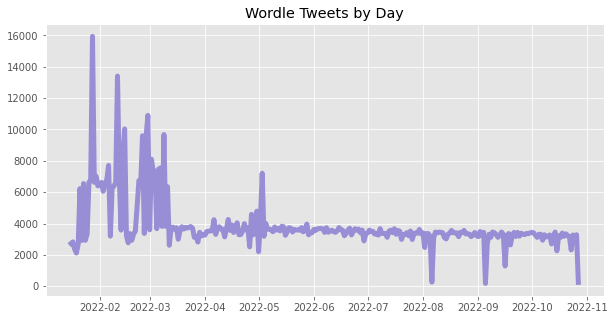

In [9]:
tweets['tweet_date'].value_counts().plot(figsize=(10,5),
                                        title='Wordle Tweets by Day',
                                        color=color_pal[2],
                                        lw=5);

### Number of Attempts Analysis

In [10]:
tweets.groupby('wordle_id')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


### How many attempts does it usually take to solve?

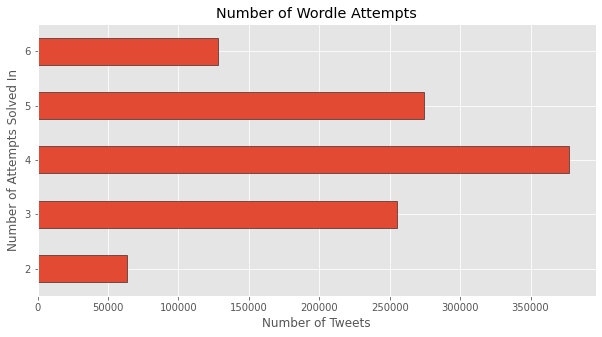

In [11]:
ax = tweets['n_attempts'].value_counts().sort_index().plot(figsize=(10,5),
                                                     kind='barh', 
                                                     title='Number of Wordle Attempts',
                                                     edgecolor='black')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved In');

### Parse Tweet Text

In [12]:
# make dark squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')

In [23]:
def parse_tweet_text(tweets):    
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1].str.contains('|'.join(['🟩','🟨','⬛'])).fillna(False)
        tweets['has_guess1'].value_counts()
        # parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1].str[:5]
        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'], 
                   f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'], 
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'], 
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

In [27]:
#keep additional tweet text
tweets['additional_text'] = tweets.loc[~tweets['tweet_text'].str.split('\n').str[-1].str.contains('🟩')] \
['tweet_text'].str.split('\n').str[-1]

In [30]:
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text,tweet_datetime,n_attempts,id,has_guess1,guess1,guess1_incorrect,guess1_wrong_spot,guess1_correct,final_guess,has_guess2,guess2,guess2_incorrect,guess2_wrong_spot,guess2_correct,has_guess3,guess3,guess3_incorrect,guess3_wrong_spot,guess3_correct,has_guess4,guess4,guess4_incorrect,guess4_wrong_spot,guess4_correct,has_guess5,guess5,guess5_incorrect,guess5_wrong_spot,guess5_correct,has_guess6,guess6,guess6_incorrect,guess6_wrong_spot,guess6_correct,additional_text
0,Wordle 210,1482553374591660037,2022-01-16,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:43+00:00,4,210,True,⬛⬛🟨🟨⬛,3,2,0,NaN,True,🟩⬛⬛⬛⬛,4.0,0.0,1.0,True,🟩🟩🟨⬛⬛,2.0,1.0,2.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
1,Wordle 210,1482553387937898499,2022-01-16,cruisecoup,Wordle 210 4/6\n\n⬛⬛⬛⬛⬛\n🟩🟩🟨🟨⬛\n🟩🟩⬛🟩🟨\n🟩🟩🟩🟩🟩,2022-01-16 03:20:46+00:00,4,210,True,⬛⬛⬛⬛⬛,5,0,0,NaN,True,🟩🟩🟨🟨⬛,1.0,2.0,2.0,True,🟩🟩⬛🟩🟨,1.0,1.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
2,Wordle 210,1482553422276698113,2022-01-16,DestroVega,Wordle 210 4/6\n\n⬛⬛⬛🟨⬛\n⬛🟩⬛🟨⬛\n⬛🟩⬛🟨⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:55+00:00,4,210,True,⬛⬛⬛🟨⬛,4,1,0,NaN,True,⬛🟩⬛🟨⬛,3.0,1.0,1.0,True,⬛🟩⬛🟨⬛,3.0,1.0,1.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
3,Wordle 210,1482553436910628866,2022-01-16,brenmardash,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟨🟨⬛⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:20:58+00:00,3,210,True,⬛⬛🟨⬛⬛,4,1,0,NaN,True,🟨🟨⬛⬛⬛,3.0,2.0,0.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
4,Wordle 210,1482553445726908420,2022-01-16,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩,2022-01-16 03:21:00+00:00,3,210,True,⬛⬛🟨⬛⬛,4,1,0,NaN,True,🟩🟩🟩⬛⬛,2.0,0.0,3.0,True,🟩🟩🟩🟩🟩,0.0,0.0,5.0,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


### Plot Results By Attempt

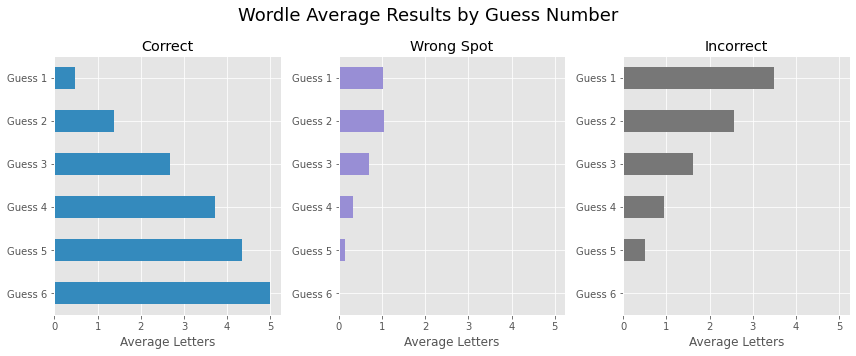

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex = True)

for i, x in enumerate(['_correct', '_wrong_spot', '_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False).plot(kind='barh', 
                                           title=f'{x.strip("_").replace("_", " ").title()}',
                                          ax=axs[i],
                                          color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

### Letter Analysis

In [40]:
answer_dict = {252 : 'SPILL',
     251 : 'VIVID',
     250 : 'BLOKE',
     249 : 'TROVE',
     248 : 'THORN',
     247 : 'OTHER',
     246 : 'TACIT',
     245 : 'SWILL',
     244 : 'DODGE',
     243 : 'SHAKE',
     242 : 'CAULK',
     241 : 'AROMA',
     240 : 'CYNIC',
     239 : 'ROBIN',
     238 : 'ULTRA',
     237 : 'ULCER',
     236 : 'PAUSE',
     235 : 'HUMOR',
     234 : 'FRAME',
     233 : 'ELDER',
     232 : 'SKILL',
     231 : 'ALOFT',
     230 : 'PLEAT',
     229 : 'SHARD',
     228 : 'MOIST',
     227 : 'THOSE',
     204 : 'GORGE',
     205 : 'QUERY',
     206 : 'DRINK',
     207 : 'FAVOR',
     208 : 'ABBEY',
     209 : 'TANGY',
     210 : 'PANIC',
     211 : 'SOLAR',
     212 : 'SHIRE',
     213 : 'PROXY',
     214 : 'POINT',
     215 : 'ROBOT',
     216 : 'PRICK',
     217 : 'WINCE',
     218 : 'CRIMP',
     219 : 'KNOLL',
     220 : 'SUGAR',
     221 : 'WHACK',
     222 : 'MOUNT',
     223 : 'PERKY',
     224 : 'COULD',
     225 : 'WRUNG',
     226 : 'LIGHT',
}

In [41]:
tweets['answer'] = tweets['id'].map(answer_dict)

In [46]:
# Counting all the letters that have been guessed correctly in the first attempt
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results = [x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

In [47]:
first_guess_correct

['I',
 'A',
 'I',
 'A',
 'I',
 'I',
 'P',
 'I',
 'A',
 'A',
 'P',
 'A',
 'I',
 'A',
 'P',
 'P',
 'P',
 'A',
 'N',
 'I',
 'I',
 'A',
 'P',
 'A',
 'A',
 'A',
 'P',
 'A',
 'A',
 'N',
 'I',
 'P',
 'A',
 'N',
 'I',
 'P',
 'A',
 'I',
 'A',
 'I',
 'C',
 'I',
 'A',
 'A',
 'P',
 'A',
 'N',
 'A',
 'A',
 'A',
 'P',
 'A',
 'P',
 'P',
 'A',
 'I',
 'P',
 'P',
 'A',
 'P',
 'A',
 'A',
 'A',
 'P',
 'N',
 'A',
 'N',
 'N',
 'A',
 'N',
 'A',
 'P',
 'P',
 'N',
 'I',
 'P',
 'P',
 'P',
 'A',
 'A',
 'I',
 'I',
 'A',
 'A',
 'I',
 'C',
 'P',
 'A',
 'I',
 'A',
 'A',
 'N',
 'A',
 'P',
 'N',
 'I',
 'P',
 'A',
 'I',
 'A',
 'A',
 'N',
 'A',
 'N',
 'I',
 'I',
 'I',
 'I',
 'P',
 'A',
 'P',
 'P',
 'A',
 'A',
 'P',
 'N',
 'I',
 'N',
 'A',
 'A',
 'I',
 'A',
 'A',
 'A',
 'P',
 'A',
 'A',
 'A',
 'I',
 'I',
 'N',
 'A',
 'I',
 'P',
 'A',
 'N',
 'A',
 'P',
 'A',
 'P',
 'A',
 'N',
 'A',
 'A',
 'I',
 'A',
 'A',
 'A',
 'N',
 'P',
 'P',
 'N',
 'I',
 'P',
 'A',
 'A',
 'N',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'P',
 'A'

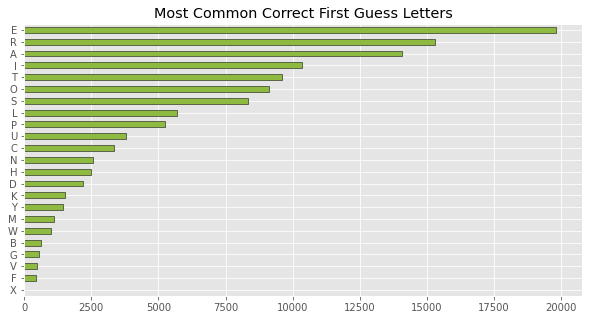

In [53]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10,5),
         title='Most Common Correct First Guess Letters', 
         edgecolor='black',
         color = color_pal[5]);